# YOLO实操教程

本章通过样例数据集演示如何在ultralytics项目中，实现YOLO模型训练及推理。  
其中采用的数据集为下采样的DOTAv1，模型采用yolov11-obb，实现旋转目标检测。  

注：本文档为初学者提供jupyter notebook形式代码演示，完整项目结构参考对应的py文件


# 一、数据集类别裁剪
对DOTAv1 数据集进行类别裁剪，选择需要训练的类别，重新生成数据集

首先通过[链接](https://github.com/ultralytics/assets/releases/download/v0.0.0/DOTAv1.zip)下载DOTAv1数据集，解压得到如下内容：
```python
.
├── images
│   ├── test
│   ├── train
│   └── val
└── labels
    ├── train
    ├── train_original
    ├── val
    └── val_original

In [2]:
import os
import shutil


def cut_data(data_dir, out_dir, setname='train'):
    original_image_dir = os.path.join(data_dir, 'images', setname)
    original_label_dir = os.path.join(data_dir, 'labels', setname)
    new_image_dir = os.path.join(out_dir, 'images', setname)
    new_label_dir = os.path.join(out_dir, 'labels', setname)
    os.makedirs(new_image_dir, exist_ok=True)
    os.makedirs(new_label_dir, exist_ok=True)

    counter = 0
    for label_file in os.listdir(original_label_dir):
        label_path = os.path.join(original_label_dir, label_file)
        new_label_path = os.path.join(new_label_dir, label_file)

        with open(label_path, 'r') as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])

            # 只保留指定类别的目标
            if class_id in keep_classes:
                # 修改类别索引
                parts[0] = str(keep_classes[class_id])
                new_lines.append(' '.join(parts) + '\n')

        # 如果有保留的目标，则保存新的标签文件和对应的图片
        if new_lines:
            with open(new_label_path, 'w') as f:
                f.writelines(new_lines)

            image_file = label_file.replace('.txt', '.jpg')
            original_image_path = os.path.join(original_image_dir, image_file)
            new_image_path = os.path.join(new_image_dir, image_file)

            shutil.copy(original_image_path, new_image_path)
            counter += 1

    print("筛选和映射完成！获得{}张图片，位于:{}".format(counter, out_dir))


In [3]:
# 原始数据路径
# 下载链接：https://github.com/ultralytics/assets/releases/download/v0.0.0/DOTAv1.zip)
data_dir = r"G:\deep_learning_data\DOTAv1"  # 配置你的数据集所在路径 !!!
data_dir_sub = os.path.join(data_dir, "DOTA-sub")  # 输出目录

In [5]:
# 需要保留的类别及其新映射
keep_classes_l = [0, 1]  # 挑选的类别，这里选择第0类和第1类。
keep_classes = {ori_class_idx: trg_index for trg_index, ori_class_idx in enumerate(keep_classes_l)}

cut_data(data_dir, data_dir_sub, setname='val')
cut_data(data_dir, data_dir_sub, setname='train')

筛选和映射完成！获得174张图片，位于:G:\deep_learning_data\DOTAv1\DOTA-sub
筛选和映射完成！获得516张图片，位于:G:\deep_learning_data\DOTAv1\DOTA-sub


# 二、图片切块
由于DOTAv1的图片分辨率从 800x800 到 4000x4000 不等，直接输入给YOLO模型，会导致目标过小，难以检测。若提高图像分辨率，对计算也带来挑战。  
为此，对于DOTA数据常用的操作是对原图进行切块，切为多个小图像块再进行目标检测模型训练。 

In [8]:
import os
from ultralytics.data.split_dota import split_test, split_trainval


data_dir_sub = r"G:\deep_learning_data\DOTAv1\DOTA-sub"  # 上一步获取得到的数据目录
data_dir_sub_split = os.path.join(os.path.dirname(data_dir), 'DOTA-sub-split')

# 对数据集图片进行切块处理，“降低”图片分辨率
split_trainval(data_root=data_dir, save_dir=data_dir_sub_split, rates=[1.0], crop_size=640, gap=50)  # gap表示重叠的像素


val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458/458 [02:03<00:00,  3.72it/s]


# 三、图片下采样

由于上万的图片训练需要较长的时间，因此可以再次挑选其中一部分图片进行构建最终的数据集。  
运行代码，设置比例为10%，可以获得469张训练图片，143张验证图片，这将构成后续训练模型的数据。

In [12]:
import shutil
import random
from tqdm import tqdm

random.seed(42)


data_dir_sub_split = r"G:\deep_learning_data\DOTAv1\DOTA-sub-split"  # 上一步得到的目录
new_data_root = data_dir_sub_split + '-downsample'
data_root = data_dir_sub_split

if os.path.exists(new_data_root):
    shutil.rmtree(new_data_root)

# 采样比例
sampling_ratio = 0.1

# 处理 train 和 val 目录
for split in ['train', 'val']:
    # 原始图片和标签路径
    split_image_dir = os.path.join(data_root, 'images', split)
    split_label_dir = os.path.join(data_root, 'labels', split)

    # 新图片和标签路径
    new_split_image_dir = os.path.join(new_data_root, 'images', split)
    new_split_label_dir = os.path.join(new_data_root, 'labels', split)
    os.makedirs(new_split_image_dir, exist_ok=True)
    os.makedirs(new_split_label_dir, exist_ok=True)

    # 获取当前 split 的所有图片文件
    label_files = [f for f in os.listdir(split_label_dir) if f.endswith(('.txt'))]
    random.shuffle(label_files)  # 随机打乱顺序

    # 计算需要采样的数量
    sample_size = int(len(label_files) * sampling_ratio)
    sampled_files = label_files[:sample_size]  # 取前10%

    # 复制采样后的图片和标签文件到新目录
    for label_file in tqdm(sampled_files):
        # 复制图片
        image_file = label_file.replace('txt', 'jpg')

        original_image_path = os.path.join(split_image_dir, image_file)
        new_image_path = os.path.join(new_split_image_dir, image_file)
        shutil.copy(original_image_path, new_image_path)

        # 复制对应的标签文件
        original_label_path = os.path.join(split_label_dir, label_file)
        new_label_path = os.path.join(new_split_label_dir, label_file)

        if os.path.exists(original_label_path):
            shutil.copy(original_label_path, new_label_path)

    print(f"{split} 下采样完成！共采样 {len(sampled_files)} 张图片和标签文件。")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 377.26it/s]


train 下采样完成！共采样 469 张图片和标签文件。


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 363.98it/s]

val 下采样完成！共采样 143 张图片和标签文件。


# 四、数据可视化
由于做了太多的处理，在训练前有必要对数据集进行可视化检查，运行代码可以得到标签可视化结果。

In [10]:
import math
import os
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


def parse_annotation(annotation_path):
    """
    解析 YOLO 格式的标注文件，返回标注信息
    """
    annotations = []
    with open(annotation_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 9:  # YOLO 格式：class_id x1 y1 x2 y2 x3 y3 x4 y4
                class_id = int(parts[0])  # 类别 ID
                coords = list(map(float, parts[1:]))  # 提取归一化的 OBB 顶点坐标
                annotations.append((class_id, coords))
    return annotations


def draw_obb(image, annotations, img_width, img_height):
    """
    在图像上绘制有向边界框（OBB）和类别标签
    """
    for ann in annotations:
        class_id, coords = ann
        # 将归一化坐标转换为实际像素坐标
        points = [(int(coords[i] * img_width), int(coords[i + 1] * img_height)) for i in range(0, 8, 2)]
        # 绘制 OBB
        for i in range(4):
            cv2.line(image, points[i], points[(i + 1) % 4], (0, 255, 0), 2)
        # 绘制类别标签
        cv2.putText(image, str(class_id), points[0], cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
    return image


def visualize_random_images(images_dir, labels_dir, num_images=4):
    """
    随机选择并可视化数据集中的图像
    """
    # 获取所有图像文件名
    labels_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
    selected_images = random.sample(labels_files, min(num_images, len(labels_files)))  # 随机选择图像

    # 动态调整 subplot 布局
    num_rows = math.ceil(math.sqrt(num_images))  # 行数
    num_cols = math.ceil(num_images / num_rows)  # 列数

    # 创建画布
    plt.figure(figsize=(num_cols * 5, num_rows * 5))  # 根据图像数量调整画布大小

    # 可视化选中的图像
    for i, label_file in enumerate(selected_images):
        # 加载图像
        image_file = label_file.replace('.txt', '.jpg')  # 标签文件名与图片文件名一致
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为 RGB 格式
        img_height, img_width, _ = image.shape  # 获取图像的宽度和高度

        # 加载标注
        annotation_path = os.path.join(labels_dir, label_file)
        annotations = parse_annotation(annotation_path)

        # 绘制 OBB 和类别标签
        image_with_boxes = draw_obb(image, annotations, img_width, img_height)

        # 显示图像
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_with_boxes)
        plt.title(image_file)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

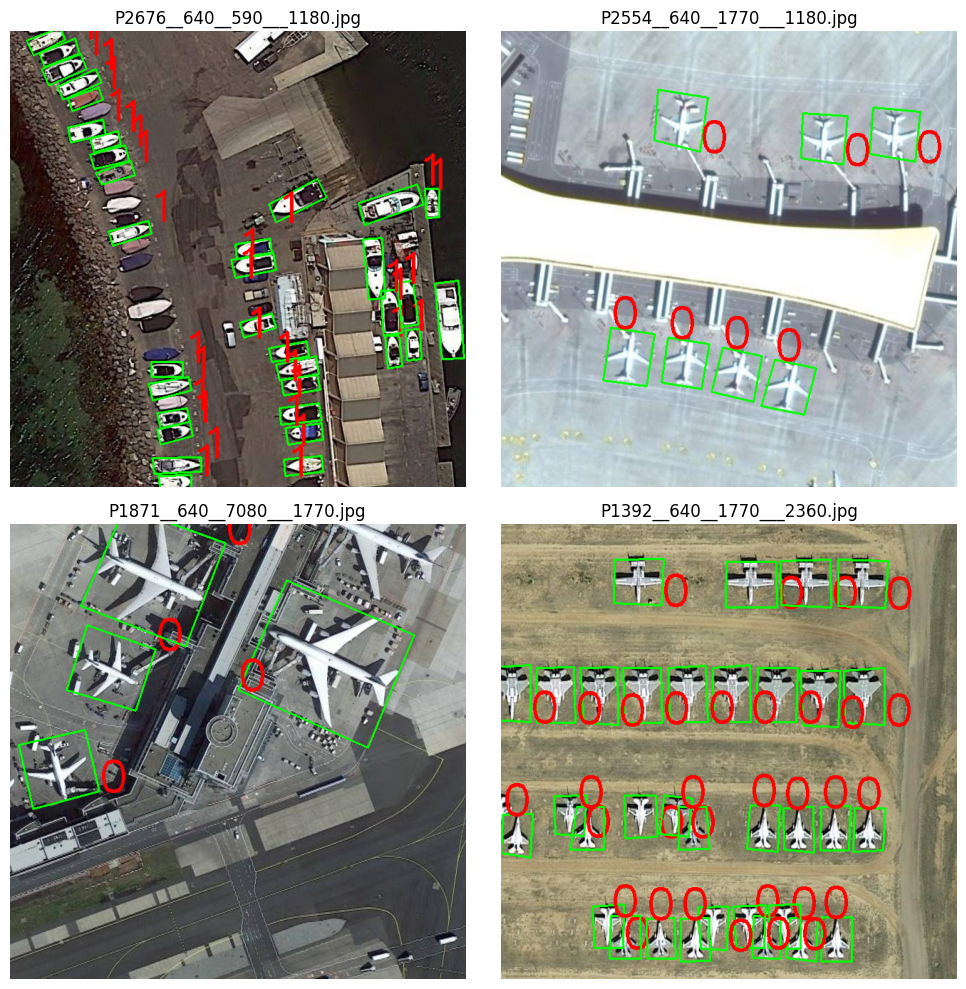

In [11]:
images_dir = r'G:\deep_learning_data\DOTAv1\DOTA-sub-split\images\train'  # 图片路径
labels_dir = r'G:\deep_learning_data\DOTAv1\DOTA-sub-split\labels\train'  # 标签路径

# 可视化随机N张图像
visualize_random_images(images_dir, labels_dir, num_images=4)

# 五、模型训练

## 特别注意事项！重要！

由于ultralytics旋转目标检测的代码问题，在训练中的验证代码里的NMS可能导致显存激增，这块目前没有好的方法，建议大家修改max_nms数量来避免。
详情可参考[issue](https://github.com/ultralytics/ultralytics/issues/7636)

具体操作：
1. 首先找到ultralytics的安装目录，然后找到对应的.py文件：ultralytics/models/yolo/obb/val.py。   
2. 对于ops.non_max_suppression函数，新增一个入参，max_nms=1920。
```python
def postprocess(self, preds):
	"""Apply Non-maximum suppression to prediction outputs."""
	return ops.non_max_suppression(
			preds,
			self.args.conf,
			self.args.iou,
			labels=self.lb,
			nc=self.nc,
			multi_label=True,
			agnostic=self.args.single_cls,
			max_det=self.args.max_det,
			max_nms=1920,  # <= Monkey patch here
			rotated=True,
	)
```


In [25]:
import ultralytics
install_dir = os.path.dirname(ultralytics.__file__)
val_path = os.path.join(install_dir, "models", 'yolo', 'obb', 'val.py')
print(f"ultralytics 安装目录: {install_dir} \n所需修改的文件路径:{val_path}")

ultralytics 安装目录: C:\Users\yts32\anaconda3\envs\pt220\lib\site-packages\ultralytics 
所需修改的文件路径:C:\Users\yts32\anaconda3\envs\pt220\lib\site-packages\ultralytics\models\yolo\obb\val.py


In [1]:
import os
from ultralytics import YOLO
BASE_DIR = os.getcwd()

# 路径配置
dataset_path = os.path.join(BASE_DIR, 'cfg', 'DOTAv1-sub.yaml')  # 数据集
yolo11n_obb_path = os.path.join(BASE_DIR, 'cfg', 'yolo11s-obb.yaml')  # 模型

# Load a model
model = YOLO(yolo11n_obb_path)

# Train the model
results = model.train(data=dataset_path, epochs=50, amp=False, batch=8)

Ultralytics 8.3.54  Python-3.10.14 torch-2.2.0 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=obb, mode=train, model=D:\github_desktop\yolo_master\code\exp-DOTA-obb\cfg\yolo11s-obb.yaml, data=D:\github_desktop\yolo_master\code\exp-DOTA-obb\cfg\DOTAv1-sub.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning G:\deep_learning_data\DOTAv1\DOTA-sub-split-downsample\labels\train.cache... 469 images, 0 backgrounds, 1 corrupt: 100%|██████████| 469/469

train: WARNING  G:\deep_learning_data\DOTAv1\DOTA-sub-split-downsample\images\train\P2641__640__4130___4985.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3063]



val: Scanning G:\deep_learning_data\DOTAv1\DOTA-sub-split-downsample\labels\val.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00


Plotting labels to runs\obb\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 


C:\Users\yts32\anaconda3\envs\pt220\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\obb\train9
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.33G      3.889      3.559      4.241         15        640: 100%|██████████| 59/59 [00:14<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.66it/s]

                   all        143       1699    0.00455      0.107    0.00305    0.00113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.43G      3.311      2.893      3.515         94        640: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.88it/s]

                   all        143       1699     0.0395      0.371     0.0323       0.01



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.41G      2.889      2.803      3.045         30        640: 100%|██████████| 59/59 [00:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.25it/s]

                   all        143       1699      0.133       0.35     0.0822     0.0231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.41G      2.817      2.626      2.951        145        640: 100%|██████████| 59/59 [00:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.42it/s]

                   all        143       1699      0.623      0.152      0.143     0.0521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.42G       2.72      2.351      2.718         56        640: 100%|██████████| 59/59 [00:11<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]

                   all        143       1699      0.338      0.413       0.29      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.42G      2.561      2.281      2.728         64        640: 100%|██████████| 59/59 [00:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.53it/s]

                   all        143       1699      0.262       0.39       0.28      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.42G      2.495      2.246      2.791         31        640: 100%|██████████| 59/59 [00:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.40it/s]

                   all        143       1699      0.426      0.459      0.394      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.43G      2.461      2.095      2.627         53        640: 100%|██████████| 59/59 [00:11<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.80it/s]

                   all        143       1699      0.555      0.571      0.561      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.47G      2.212      1.844      2.511          7        640: 100%|██████████| 59/59 [00:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]

                   all        143       1699       0.63      0.608      0.619      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.41G      2.104       1.71      2.437         21        640: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]

                   all        143       1699      0.684      0.661      0.708      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.42G      2.109      1.705        2.4         45        640: 100%|██████████| 59/59 [00:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        143       1699       0.71       0.63      0.704      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.42G      2.061      1.663      2.459         27        640: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.33it/s]

                   all        143       1699      0.619       0.65      0.672      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.43G      1.965      1.613      2.298         26        640: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.59it/s]

                   all        143       1699      0.746      0.674      0.759      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.42G      1.978      1.612      2.356         45        640: 100%|██████████| 59/59 [00:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.15it/s]

                   all        143       1699      0.807      0.667      0.768       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.43G       1.92      1.512      2.353         27        640: 100%|██████████| 59/59 [00:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.69it/s]

                   all        143       1699       0.69      0.716      0.732      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.41G      1.957      1.536      2.324         72        640: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.43it/s]

                   all        143       1699      0.787      0.712      0.787      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.43G      1.792      1.434      2.227         50        640: 100%|██████████| 59/59 [00:11<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.26it/s]

                   all        143       1699        0.8      0.695      0.788      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       4.4G       1.86      1.456      2.296        109        640: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]

                   all        143       1699      0.821        0.8      0.856      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.44G       1.77      1.351      2.226         41        640: 100%|██████████| 59/59 [00:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.36it/s]

                   all        143       1699      0.813      0.798      0.844      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.43G      1.732      1.405        2.2         33        640: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.38it/s]

                   all        143       1699      0.824      0.721      0.815      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.42G      1.704      1.363        2.2         99        640: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.40it/s]

                   all        143       1699      0.851      0.782      0.855      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.43G      1.652      1.292      2.097         19        640: 100%|██████████| 59/59 [00:11<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.61it/s]

                   all        143       1699      0.793      0.785      0.834      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.43G      1.698      1.312      2.151         28        640: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.28it/s]

                   all        143       1699      0.833      0.789      0.862      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       4.4G      1.623      1.275      2.075         81        640: 100%|██████████| 59/59 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.78it/s]

                   all        143       1699      0.835      0.799      0.868       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.43G      1.713      1.281      2.162         42        640: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.53it/s]

                   all        143       1699      0.813      0.752      0.828      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       4.4G      1.583      1.211      2.048         12        640: 100%|██████████| 59/59 [00:11<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.60it/s]

                   all        143       1699      0.866      0.783      0.868      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.42G      1.563      1.212      2.072        122        640: 100%|██████████| 59/59 [00:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.40it/s]

                   all        143       1699      0.825      0.776      0.847      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.43G      1.543      1.218      2.152         23        640: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.83it/s]

                   all        143       1699      0.865      0.809      0.882      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.43G      1.533       1.17      2.074         64        640: 100%|██████████| 59/59 [00:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.80it/s]

                   all        143       1699       0.86      0.801      0.872      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.42G      1.508      1.176      2.057         57        640: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.54it/s]

                   all        143       1699      0.854      0.804      0.871      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.41G      1.469       1.15      2.021         83        640: 100%|██████████| 59/59 [00:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.56it/s]

                   all        143       1699      0.847        0.8      0.881      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.41G      1.497      1.143      2.054         29        640: 100%|██████████| 59/59 [00:11<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.69it/s]

                   all        143       1699      0.865      0.828      0.894      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.43G      1.584       1.16      2.074         49        640: 100%|██████████| 59/59 [00:11<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.51it/s]

                   all        143       1699      0.851       0.81      0.871      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       4.4G      1.477      1.099      1.965         41        640: 100%|██████████| 59/59 [00:11<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.40it/s]

                   all        143       1699      0.837       0.84      0.892      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.45G      1.461      1.094      2.031        160        640: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.41it/s]

                   all        143       1699      0.853      0.804      0.882      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.43G      1.473      1.101      1.995         38        640: 100%|██████████| 59/59 [00:11<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.75it/s]

                   all        143       1699      0.853      0.847      0.904      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.41G      1.436      1.062      1.957         71        640: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.64it/s]

                   all        143       1699      0.866      0.855      0.908       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.43G      1.421      1.046      1.948         49        640: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.62it/s]

                   all        143       1699      0.869      0.837       0.89       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.45G      1.427      1.065      2.009         60        640: 100%|██████████| 59/59 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.63it/s]

                   all        143       1699      0.864      0.846      0.901      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.41G      1.374      0.991      1.947         43        640: 100%|██████████| 59/59 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.62it/s]

                   all        143       1699       0.86      0.846      0.897      0.635


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.43G      1.397      1.096      2.022         21        640: 100%|██████████| 59/59 [00:12<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]

                   all        143       1699      0.858      0.832      0.901      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       4.4G      1.386      1.079      2.004         12        640: 100%|██████████| 59/59 [00:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.77it/s]

                   all        143       1699      0.854      0.852      0.897      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.43G      1.317      1.012      1.972         10        640: 100%|██████████| 59/59 [00:11<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.51it/s]

                   all        143       1699      0.883      0.835      0.905      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.43G      1.304      1.015      2.056         68        640: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]

                   all        143       1699      0.854      0.862      0.907      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.42G      1.342      1.028      2.085         27        640: 100%|██████████| 59/59 [00:11<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.95it/s]

                   all        143       1699      0.863       0.86      0.907       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.43G      1.313      1.027      2.009         17        640: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.82it/s]

                   all        143       1699       0.85      0.865      0.903      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.43G      1.306     0.9964      2.057         24        640: 100%|██████████| 59/59 [00:11<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.04it/s]

                   all        143       1699      0.888      0.834      0.911      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.41G      1.331      1.015      2.037         13        640: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.80it/s]

                   all        143       1699       0.86      0.859      0.905      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.43G      1.318     0.9782      1.964         13        640: 100%|██████████| 59/59 [00:11<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.38it/s]

                   all        143       1699      0.876      0.863      0.913      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       4.4G      1.304     0.9699      1.931         12        640: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.51it/s]

                   all        143       1699      0.862      0.869      0.912      0.661



50 epochs completed in 0.215 hours.
Optimizer stripped from runs\obb\train9\weights\last.pt, 20.0MB
Optimizer stripped from runs\obb\train9\weights\best.pt, 20.0MB

Validating runs\obb\train9\weights\best.pt...
Ultralytics 8.3.54  Python-3.10.14 torch-2.2.0 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11s-obb summary (fused): 257 layers, 9,699,561 parameters, 0 gradients, 22.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.38it/s]


                   all        143       1699      0.876      0.863      0.913      0.666
                 plane         66        270      0.899       0.89       0.93      0.719
                  ship         77       1429      0.854      0.836      0.895      0.612
Speed: 0.5ms preprocess, 7.7ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\obb\train9


# 六、模型评估

In [2]:
dataset_path = os.path.join(BASE_DIR, 'cfg', 'DOTAv1-sub.yaml')  # 数据集
weights_path = os.path.join(BASE_DIR, 'runs', 'obb', 'train9', 'weights', 'best.pt')  # 模型

model = YOLO(weights_path)
metrics = model.val(data=dataset_path, imgsz=640, batch=16, conf=0.25, iou=0.6)

Ultralytics 8.3.54  Python-3.10.14 torch-2.2.0 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11s-obb summary (fused): 257 layers, 9,699,561 parameters, 0 gradients, 22.3 GFLOPs


val: Scanning G:\deep_learning_data\DOTAv1\DOTA-sub-split-downsample\labels\val.cache... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


                   all        143       1699      0.882      0.867      0.913      0.695
                 plane         66        270      0.899      0.892      0.929      0.745
                  ship         77       1429      0.865      0.841      0.897      0.644
Speed: 1.4ms preprocess, 14.1ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs\obb\val5


# 七、模型推理


image 1/1 G:\deep_learning_data\DOTAv1\DOTA-sub-split-downsample\images\val\P2231__640__590___1180.jpg: 1024x1024 44.0ms
Speed: 16.0ms preprocess, 44.0ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)
[     466.16      438.61      62.214      58.886     0.19162]
xywhr转换后得到四个顶点： [[430 461]
 [441 403]
 [502 415]
 [491 473]]


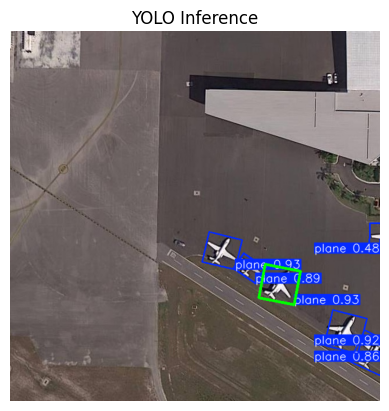

In [12]:
import cv2
import numpy as np
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
%matplotlib inline
BASE_DIR = os.getcwd()


# 路径配置
weights_path = os.path.join(BASE_DIR, 'runs', 'obb', 'train', 'weights', 'best.pt')  
image_path = r"G:\deep_learning_data\DOTAv1\DOTA-sub-split-downsample\images\val\P2231__640__590___1180.jpg" 

# ========================== step1: 初始化YOLO对象 ==========================
model = YOLO(weights_path)

# ========================== step2: 执行推理 ==========================
results = model(image_path, conf=0.1, iou=0.7)  # 推理配置
annotated_frame = results[0].plot()  # 检测框结果绘制

# ========================== step3: OBB预测分析 ==========================
xywhr_pred = np.array(results[0].obb[0].xywhr.to('cpu'))[0]
print(xywhr_pred)

# 获取旋转矩形框的四个顶点
cx, cy, w, h, angle = xywhr_pred
angle = angle * 180 / np.pi
rect = ((cx, cy), (w, h), angle)
box = cv2.boxPoints(rect)  # 获取四个顶点坐标
box = np.int0(box)  # 转换为整数
print("xywhr转换后得到四个顶点：", box)

# 在图像上绘制旋转矩形框
cv2.polylines(annotated_frame, [box], isClosed=True, color=(0, 255, 0), thickness=3)  # 绿色框是手动根据模型预测结果绘制的

plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))  # OpenCV 使用 BGR 格式，转换为 RGB
plt.title("YOLO Inference")
plt.axis('off')  # 不显示坐标轴
plt.show()

